In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

###  SVM Decision function

In the dual form, the decision function of an SVM is given as,

$$
f(\mathbf{\mathbf{x}}) = \sum_{i=1}^N \alpha_iy_i\kappa(\mathbf{x}_i, \mathbf{x}) + b,
$$

and a prediction is then made as $\text{sgn}\big(f(\mathbf{x})\big)$ where $\text{sgn} : x \to \{1, -1\}$ is the sign function. One can see how an observation $\mathbf{x}$ is classified according to its similarity with the training vectors. Each training vector, $\mathbf{x}_i$, casts its vote, $y_i$, be it $-1$ or $1$, with the influence regulated by a similarity measure provided by the kernel function, and the weight provided by the dual variable. Only the support vectors have a (non-zero) weighted vote. It is easy to see why this is such a powerful framework--we can choose between many similarity measures (kernels), though the mathematics restricts us to choosing Mercer kernels.

**Question:** Write the `decision_function()` (not the prediction) for an SVM. Assume `Ki` is a precomputed vector giving all kernel values $\kappa(\mathbf{x}_i, \mathbf{x})$:

## Coding an SVM

We have coded a working SVM with a simplified version of the specialised SMO algorithm (see below). It is based on a tutorial from Stanford course CS229 (http://cs229.stanford.edu/materials/smo.pdf). Since it is a messy algorithm, we will walk through it and ask you to code small parts only. For future reference, recall the form of an SVM in the dual form:

\begin{equation}
\begin{array}{rl}
\max_{\boldsymbol\alpha} & W(\boldsymbol\alpha) = \sum_{i = 1}^{N}\alpha_i + \frac{1}{2}\sum_{i}^N\sum_{j}^N \alpha_i\alpha_jy_iy_j\mathbf{x}_i^T\mathbf{x}_j \\
\text{subject to} & \sum_{i=1}^N \alpha_iy_i = 0 \\
& 0 \leq \alpha_i \leq C, \forall i
\end{array}
\end{equation}

In [6]:
def decision_function(Ki, y, a, b):
    # TODO
    return Ki@(np.diag(y)@a) + b

### Sequential Minimal Optimisation

Our model may be solved with any QP solver, formerly the standard approach. However, in 1998, American computer scientist, John Platt (1963-), invented sequential minimal optimisation (SMO), an algorithm for analytically optimising the dual variables two at a time. The superiority and simplicity of this algorithm helped bring support vector machines into the forefront of machine learning research. The algorithm works by iteratively optimising pairs of variables that violate the optimality conditions. These are,

\begin{align}
\begin{array}{rcl}
\alpha_i = 0 & \implies & y_if(\mathbf{x}_i) \geq 1 \notag\\
0 < \alpha_i < C  & \implies & y_if(\mathbf{x}_i) = 1 \notag \\
\alpha_i = C & \implies & y_if(\mathbf{x}_i) \leq 1 \notag
\end{array}
\end{align}

#### Updating the weights

Optimisation is done *in pairs* (this is what *minimal* refers to in SMO) in order to maintain the equality constraint of the problem, $\sum_{i=1}^N \alpha_iy_i = 0$ (see above). Thus, for pair $\alpha_i$ and $\alpha_j$, we make updates such that $y_i\Delta\alpha_i + y_j\Delta\alpha_j = 0$. Rearranging gives $\Delta\alpha_j = -\Delta\alpha_iy^{(i)}/y^{(j)} = -\Delta\alpha_iy^{(i)}y^{(j)}$, as since $y_i \in \{-1, 1\}$, division is the same as multiplication, and the cost function becomes,

\begin{align}
W(\boldsymbol\alpha) &= \sum_{k=1}^N\alpha_k + \Delta\alpha_i -\Delta\alpha_iy_iy_j - \frac{1}{2}\sum_{k=1}^Ny_k\alpha_k\big(f(\mathbf{x}_k) - b\big) \notag \\ 
&- \Delta\alpha_i\big(f(\mathbf{x}_i) - f(\mathbf{x}_j)\big) - \Delta\alpha_iy_i\big(f(\mathbf{x}_i) - f(\mathbf{x}_j)\big) - \frac{1}{2}\Delta\alpha_i^2\big(\kappa(\mathbf{x}_i, \mathbf{x}_i) - 2\kappa(\mathbf{x}_i, \mathbf{x}_j) + \kappa(\mathbf{x}_j, \mathbf{x}_j)\big). \notag 
\end{align}

Differentiating and solving gives,

$$\Delta\alpha_j^* = \frac{y_j(E_i - E_j)}{2\kappa(\mathbf{x}_i, \mathbf{x}_j) - \kappa(\mathbf{x}_i, \mathbf{x}_i) - \kappa(\mathbf{x}_j, \mathbf{x}_j)},$$

where $E_i = f(\mathbf{x}_i) - y_i$ and $E_j = f(\mathbf{x}_j) - y_j$ are the errors.

**Question:** Write the function to calculate `delta_a()`. Use `i` and `j` to index the kernel matrix. Note that for simplicity, we assume the errors have been calculated already:

In [7]:
def delta_a(K, y, i, j, Ei, Ej):
    delta_a = float(y[j] * (Ei - Ej)) / (2 * K[i, j] - K[i, i] - K[j, j]) # TODO
    return delta_a

This gives us our update step. The value of $\Delta\alpha_j^*$ can then be determined from the initial equality. Note that both variables remain constrained, hence their values must be clipped if they are less than $0$ or greater than $C$.

#### Updating the bias

The bias term is then updated to account for the changes. For example, to ensure the classifier now emits $y_i$ for $f(\mathbf{x}_i)$, we rearrange,

$$y_i = \sum_{k=1}^N \alpha_iy_i\kappa(\mathbf{x}_k, \mathbf{x}_i) + b + \Delta b + \Delta\alpha y_i\kappa(\mathbf{x}_i, \mathbf{x}_i) + \Delta\alpha y_j\kappa(\mathbf{x}_i, \mathbf{x}_j),$$

for $\Delta b^*$. The same is done for $f(\mathbf{x}_j)$, and the expressions are combined according to the convergence conditions. Thus, the optimisation steps are done analytically, rather than with linear algebra. The rest of the algorithm is mostly concerned with heuristics for choosing the best $\alpha_i$, $\alpha_j$ pair.

### Putting it all together

Your functions will be called by the class `SupportVectorMachine` defined below. *(you do not need to change anything, just compile it and move on...)*

In [14]:
from sklearn.metrics.pairwise import rbf_kernel

class SupportVectorMachine:

    def __init__(self, kernel='linear', gamma=0.01, d=2, r=0):

        """ Initialisation function for support vector machine

        Parameters:
        -----------
        kernel: {linear, rbf, polynomial} string
                Indicates the kernel function to use
        gamma:  float
                Variance of rbf kernel
        d:      float
                Degree for polynomial kernel
        r:      float
                Consant for polynomial kernel
        """
        if kernel == 'linear':
            self.kernel = lambda x, y : x.dot(y.T)
        elif kernel == 'rbf':
            self.kernel = lambda x, y : rbf_kernel(x, y, gamma=0.01)
        elif kernel == 'polynomial':
            self.kernel = lambda x, y : (x.dot(y.T) + r) ** d

    def predict(self, x):

        """ Prediction function for support vector machine

        Parameters:
        -----------
        x:      (1, n_features) np.array
                Test sample

        Return:
        -------
        prediction: {-1, 1}
            Sign of output of linear score function
        """
        # calculate kernel values for input x
        kx = self.kernel(self.Xtr, x.reshape(1, -1))
        return np.sign(self.a.dot(np.diag(ytr)).dot(kx) + self.b)

    def decision_function(self, Ki):

        """ Decision function for support vector machine

        Parameters:
        -----------
        x:      (1, n_features) np.array
                Test sample

        Return:
        -------
        prediction: float
            Output of linear score function
        """
        return decision_function(Ki, self.ytr, self.a, self.b)

    def fit(self, Xtr, ytr, C=0.01, tol=1e-5, max_iters=100):

        """ Training algorithm for support vector machine.
        
        SMO sequential minimal optimisation algorithm for training. 
        This is the simplified version (without heuristics) detailed in
        cs229.stanford.edu/materials/smo.pdf

        Parameters:
        -----------
        Xtr:       (n_samples, n_features) np.array
                   First data matrix.
        ytr:       (n_samples, 1) np.array
                   Second data matrix.
        C:         float
                   margin size
        tol:       float
                   precision on optimality (stopping condition)
        max_iters: int
                   maximum number of optimisation passes"""

        self.Xtr = Xtr
        self.ytr = ytr

        N = self.Xtr.shape[0]
        K = self.kernel(self.Xtr, self.Xtr)  # kernel matrix

        self.a = np.zeros(N)  # support vector weights
        self.b = 0  # bias term

        iters = 0

        while iters < max_iters:
            num_changed = 0
            # iterate over samples
            for i in range(N):
                # Calculate error
                Ei = self.decision_function(K[i]) - self.ytr[i]
                # Check optimality constraints
                
                if (self.ytr[i] * Ei < -tol and self.a[i] < C) or \
                   (self.ytr[i] * Ei > +tol and self.a[i] > 0):

                    # Pick random aj
                    j = np.random.choice(filter(lambda x : x != i, range(N)))
                    Ej = self.decision_function(K[j]) - self.ytr[j]

                    # Record ai, aj
                    ai_old = self.a[i]
                    aj_old = self.a[j]

                    # Set bounds
                    L = 0 ; H = 0
                    if self.ytr[i] != self.ytr[j]:
                        L = max(0, self.a[j] - self.a[i])
                        H = min(C, C + self.a[j] - self.a[i])
                    else:
                        L = max(0, self.a[i] + self.a[j] - C)
                        H = min(C, self.a[i] + self.a[j])

                    if L == H:
                        continue
    
                    # Update aj
                    self.a[j] -= delta_a(K, self.ytr, i, j, Ei, Ej)

                    # Clip value
                    self.a[j] = max(min(self.a[j], H), L)

                    # Check for change
                    if abs(self.a[j] - aj_old) < tol:
                        continue

                    # Update ai
                    self.a[i] += self.ytr[i] * self.ytr[j] * (aj_old - self.a[j])

                    # Set bias term
                    b1 = self.b - Ei - \
                         self.ytr[i] * (self.a[i] - ai_old) * K[i, i] - \
                         self.ytr[j] * (self.a[j] - aj_old) * K[i, j]

                    b2 = self.b - Ej - \
                         self.ytr[i] * (self.a[i] - ai_old) * K[i, j] - \
                         self.ytr[j] * (self.a[j] - aj_old) * K[j, j]

                    if 0 < self.a[i] and self.a[i] < C:
                        self.b = b1
                    elif 0 < self.a[j] and self.a[j] < C:
                        self.b = b2
                    else:
                        self.b = float(b1 + b2) / 2

                    num_changed += 1

            iters = iters + 1 if num_changed == 0 else 0

### Linearly separable data

We will now test our implementation on some toy data. We being by creating a random dataset sampled from two distinct Gaussians:

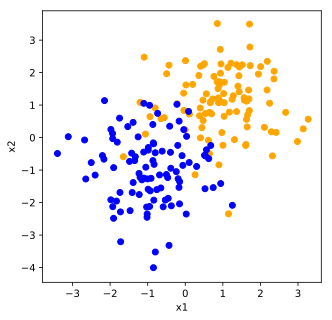

In [15]:
from numpy.random import multivariate_normal

num_samples = 100

X = np.concatenate((multivariate_normal(mean=np.array([1, 1]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples),
                    multivariate_normal(mean=np.array([-1, -1]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples)))

y = np.array(num_samples * [1] + num_samples * [-1])

# visualise mesh as contour plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('x1') ; ax.set_ylabel('x2')

# plot training data
plt.scatter(X[:num_samples, 0], X[:num_samples, 1], color='orange')
plt.scatter(X[num_samples:, 0], X[num_samples:, 1], color='blue')

Now let's train our custom SVM with a linear kernel:

In [16]:
# create train-test split
from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(X, y)

# train linear SVM
clf = SupportVectorMachine(kernel='linear')
clf.fit(Xtr, ytr, C=0.5, max_iters=100)

# calculate accuracy on test set
linear_pred = np.array([clf.predict(xte) for xte in Xte]).reshape(yte.shape[0])
acc = float(sum(linear_pred==yte)) / yte.shape[0]
print('Accuracy (linear): %.00f%%' % (100 * acc))

ValueError: 'a' must be 1-dimensional or an integer

Visualise decision boundary:

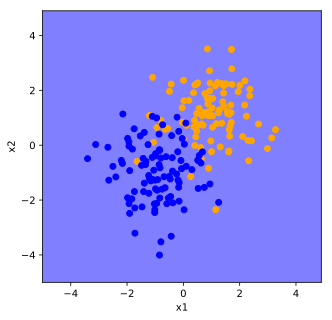

In [17]:
# create mesh coordinates
lim = 5
xx, yy = np.meshgrid(np.arange(-lim, +lim, 0.1),
                     np.arange(-lim, +lim, 0.1))
zz = np.zeros(xx.shape)

# create mesh of predictions
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz[i, j] = clf.predict(np.array([xx[i, j], yy[i, j]]))

# visualise mesh as contour plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('x1') ; ax.set_ylabel('x2')
ax.set_xlim([-lim, +lim-0.1]) ; ax.set_ylim([-lim, +lim-0.1])
ax.contourf(xx, yy, zz, alpha=0.5, colors=('blue', 'orange'))

# plot training data
plt.scatter(X[:num_samples, 0], X[:num_samples, 1], color='orange')
plt.scatter(X[num_samples:, 0], X[num_samples:, 1], color='blue')

No problem! Now for something a little more challenging...

### Non-linear decision boundaries

Now we will try data that is not linearly separable: a circle inside a square! We will see that our linear kernel is insufficient:

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

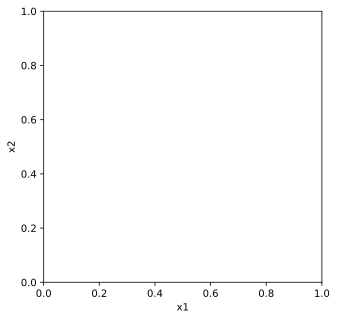

In [18]:
from numpy.random import multivariate_normal

num_samples = 200

X = np.random.uniform(low=-1, high=1, size=(num_samples, 2))
y = np.array([1 if np.sqrt(np.dot(x, x.T)) < 1 / np.sqrt(2) else -1 for x in X])

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('x1') ; ax.set_ylabel('x2')

class_pos = filter(lambda i : y[i] == +1,  np.arange(X.shape[0]))
class_neg = filter(lambda i : y[i] == -1,  np.arange(X.shape[0]))

# plot training data
plt.scatter(X[class_pos, 0], X[class_pos, 1], color='orange')
plt.scatter(X[class_neg, 0], X[class_neg, 1], color='blue')

Uh oh! Polynomial kernels to the rescue!

In [20]:
# create train-test split
Xtr, Xte, ytr, yte = train_test_split(X, y)

# train linear SVM
clf_linear = SupportVectorMachine(kernel='linear')
clf_linear.fit(Xtr, ytr, C=0.1, max_iters=100)

# calculate accuracy on test set
linear_pred = np.array([clf_linear.predict(xte) for xte in Xte]).reshape(yte.shape[0])
acc = float(sum(linear_pred==yte)) / yte.shape[0]
print('Accuracy (linear): %.00f%%' % (100 * acc))

# train quadratic kernel SVM
clf_poly = SupportVectorMachine(kernel='polynomial')#TODO 
clf_poly.fit(Xtr, ytr, C=0.5, max_iters=100)

# calculate accuracy on test set
quad_pred = np.array([clf_poly.predict(xte) for xte in Xte]).reshape(yte.shape[0])
acc = float(sum(quad_pred==yte)) / yte.shape[0]
print('Accuracy (quadratic): %.00f%%' % (100 * acc))

ValueError: 'a' must be 1-dimensional or an integer

We plot the decision boundaries for the quadratic kernel:

In [21]:
# create mesh coordinates
lim = 1
xx, yy = np.meshgrid(np.arange(-lim, +lim, 0.1), np.arange(-lim, +lim, 0.1))
zz_poly = np.zeros(xx.shape)

# create mesh of predictions
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz_poly[i, j] = clf_poly.predict(np.array([xx[i, j], yy[i, j]]))

# visualise mesh as contour plot
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('x1') ; ax.set_ylabel('x2')
ax.set_xlim([-lim, +lim-0.1]) ; ax.set_ylim([-lim, +lim-0.1])
ax.contourf(xx, yy, zz_poly, alpha=0.5, colors=('blue', 'orange'))

# plot training data
ax.scatter(X[class_pos, 0], X[class_pos, 1], color='orange')
ax.scatter(X[class_neg, 0], X[class_neg, 1], color='blue')

NameError: name 'clf_poly' is not defined

The data is linearly separable in quadratic space!

### Non-linear decision boundaries: learning XOR

A classic challenge to the power of a classifier is data arranged in an XOR pattern. Let us begin by defining data approximating and XOR function.

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

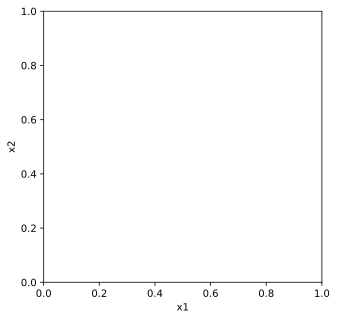

In [22]:
from numpy.random import multivariate_normal

num_samples = 50

X = np.concatenate((multivariate_normal(mean=np.array([2, 2]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples),
                    multivariate_normal(mean=np.array([-2, -2]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples),
                    multivariate_normal(mean=np.array([2, -2]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples),
                    multivariate_normal(mean=np.array([-2, 2]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples)))

y = np.array(2 * num_samples * [1] + 2 * num_samples * [-1])

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('x1') ; ax.set_ylabel('x2')

class_pos = filter(lambda i : y[i] == +1,  np.arange(X.shape[0]))
class_neg = filter(lambda i : y[i] == -1,  np.arange(X.shape[0]))

# plot training data
plt.scatter(X[class_pos, 0], X[class_pos, 1], color='orange')
plt.scatter(X[class_neg, 0], X[class_neg, 1], color='blue')

Now let's see how a linear kernel performs against an rbf kernel.

In [23]:
# create train-test split
Xtr, Xte, ytr, yte = train_test_split(X, y)

# train linear SVM
clf_linear = SupportVectorMachine(kernel='linear')
clf_linear.fit(Xtr, ytr, C=0.1, max_iters=100)

# calculate accuracy on test set
linear_pred = np.array([clf_linear.predict(xte) for xte in Xte]).reshape(yte.shape[0])
acc = float(sum(linear_pred==yte)) / yte.shape[0]
print('Accuracy (linear): %.00f%%' % (100 * acc))

# train rbf svm
clf_rbf = SupportVectorMachine(kernel='rbf', gamma=2)
clf_rbf.fit(Xtr, ytr, C=1, max_iters=100)# TODO

# calculate accuracy on test set
quad_pred = np.array([clf_rbf.predict(xte) for xte in Xte]).reshape(yte.shape[0])
acc = float(sum(quad_pred==yte)) / yte.shape[0]
print('Accuracy (rbf): %.00f%%' % (100 * acc))

ValueError: 'a' must be 1-dimensional or an integer

Finally, we visualise the rbf-SVM decision boundaries:

In [24]:
# create mesh coordinates
lim = 4
xx, yy = np.meshgrid(np.arange(-lim, +lim, 0.1), np.arange(-lim, +lim, 0.1))
zz_rbf = np.zeros(xx.shape)

# create mesh of predictions
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz_rbf[i, j] = clf_rbf.predict(np.array([xx[i, j], yy[i, j]]))

# visualise mesh as contour plot
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('x1') ; ax.set_ylabel('x2')
ax.set_xlim([-lim, +lim-0.1]) ; ax.set_ylim([-lim, +lim-0.1])
ax.contourf(xx, yy, zz_rbf, alpha=0.5, colors=('blue', 'orange'))

# plot training data
ax.scatter(X[class_pos, 0], X[class_pos, 1], color='orange')
ax.scatter(X[class_neg, 0], X[class_neg, 1], color='blue')

NameError: name 'clf_rbf' is not defined